# **Fitting two-stage task.**

Implemented by Jungsun Yoo on 2025-08-04

In [ ]:
import pytensor
pytensor.config.mode = "FAST_COMPILE"
pytensor.config.cxx = ""  # disables C++ compilation

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functools import partial
from scipy.stats import spearmanr

# Import HSSM and simulator package
import hssm
from hssm.utils import decorate_atomic_simulator
from hssm.likelihoods.rldm import make_rldm_logp_op
from hssm.distribution_utils.dist import make_hssm_rv
from ssms.basic_simulators.simulator import simulator

from hssm.likelihoods.rldm import make_jax_logp_ops, rlssm1_logp_inner_func, rlssm2_tst_1step_logp_inner_func, make_rldm_logp_op, make_logp_func  
import jax
import jax.numpy as jnp

from jax import jit, vmap, grad, value_and_grad

/opt/anaconda3/envs/hssm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set the style for the plots
plt.style.use('seaborn-v0_8-dark-palette')


: 

## Load and prepare the dataset
This data file contains (synthetic) data from a simulated 2-armed bandit task. We examine the dataset -- it contains the typical columns that are expected from a canonical instrumental learning task. `participant_id` identifies the subject id, `trial` identifies the sequence of trials within the subject data, `response` and `rt` are the data columns recorded for each trial, `feedback` column shows the reward obtained on a given trial and `correct` records whether the response was correct. 

### Step 1: Define a pytensor RandomVariable

In [ ]:
# Test the likelihood function by evaluating it with dummy parameters and data extracted from the dataset.

def extract_data_columns(dataset, two_step = False):
    """Extract required data columns from dataset and return as DataFrame."""
    if two_step:
        # For two-step task, extract additional columns
        data_dict = {
            'participant_id': dataset["participant_id"].values,
            'trial': dataset["trial_id"].values,
            'response': dataset["response"].values,
            'response2': dataset["response2"].values,
            'feedback': dataset["feedback"].values,
            'rt': dataset["rt"].values,
            'state1': dataset["state1"].values,
            'state2': dataset["state2"].values
        }
    else:
        data_dict = {
            'participant_id': dataset["participant_id"].values,
            'trial': dataset["trial_id"].values,
            'response': dataset["response"].values,
            'feedback': dataset["feedback"].values,
            'rt': dataset["rt"].values
        }
        
    return pd.DataFrame(data_dict)

def create_test_parameters(n_trials, two_step = False):
    """Create dummy parameters for testing the likelihood function."""
    if two_step:
        return {
            'rl_alpha': np.ones(n_trials) * 0.60,
            'scaler': np.ones(n_trials) * 3.2,
            'a': np.ones(n_trials) * 1.2,
            'z': np.ones(n_trials) * 0.1,
            't': np.ones(n_trials) * 0.1,
            'theta': np.ones(n_trials) * 0.1,
            'w': np.ones(n_trials) * 0.5,
        }
    else:   
        return {
            'rl_alpha': np.ones(n_trials) * 0.60,
            'scaler': np.ones(n_trials) * 3.2,
            'a': np.ones(n_trials) * 1.2,
            'z': np.ones(n_trials) * 0.1,
            't': np.ones(n_trials) * 0.1,
            'theta': np.ones(n_trials) * 0.1
    }

# ...existing code...
def add_valid_upto_and_pad(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["participant_id", "trial_id"]).reset_index(drop=True)
    counts = df.groupby("participant_id").size()
    max_len = int(counts.max())

    def pad_group(g):
        g = g.copy()
        n = int(len(g))
        g["valid_upto"] = n
        if n < max_len:
            pid = int(g["participant_id"].iloc[0])
            start_trial = int(g["trial_id"].max()) + 1
            pad_len = max_len - n
            tail = pd.DataFrame({
                "participant_id": pid,
                "trial_id": np.arange(start_trial, start_trial + pad_len, dtype=int),
                "response": 0,
                "response2": 0,
                "rt": 0.0,
                "feedback": 0.0,
                "state1": 0,
                "state2": 0,
                "valid_upto": n,
            })
            g = pd.concat([g, tail], ignore_index=True)
        return g

    out = df.groupby("participant_id", group_keys=False).apply(pad_group).reset_index(drop=True)
    for c in ["participant_id", "trial_id", "response", "response2", "state1", "state2", "valid_upto"]:
        if c in out.columns:
            out[c] = out[c].astype("int64")
    return out



: 

: 

: 

: 

In [ ]:
nstate=2
csv_filename = 'hddm2_fixed_final_' + str(nstate) + 'states.csv'

# Load synthetic RLSSM dataset containing both behavioral data and ground truth parameters
# savefile = np.load(csv_filename, allow_pickle=True)
dataset = pd.read_csv(csv_filename, index_col=0)
dataset

,subj_idx,rt1,rt2,response1,response2,state1,state2,feedback,trial,cond,q_init,isleft1,isleft2,split_by
1,0.0,1.139,1.345,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.5,1.0,0.0,1.0
2,0.0,0.781,1.268,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0
3,0.0,0.439,1.879,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.5,1.0,1.0,1.0
4,0.0,0.892,1.111,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.5,0.0,1.0,1.0
5,0.0,0.479,0.964,0.0,1.0,0.0,0.0,0.0,4.0,1.0,0.5,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,107.0,0.411,0.366,1.0,1.0,0.0,0.0,1.0,292.0,1.0,0.5,0.0,1.0,1.0
29527,107.0,0.688,0.802,1.0,1.0,0.0,1.0,0.0,293.0,1.0,0.5,1.0,0.0,1.0
29528,107.0,0.328,0.340,0.0,0.0,0.0,0.0,0.0,294.0,1.0,0.5,1.0,0.0,1.0
29529,107.0,0.308,0.399,1.0,1.0,0.0,1.0,1.0,295.0,1.0,0.5,1.0,0.0,1.0


: 

: 

: 

: 

In [ ]:

nstate=2
csv_filename = 'hddm2_fixed_final_' + str(nstate) + 'states.csv'

# Load synthetic RLSSM dataset containing both behavioral data and ground truth parameters
# savefile = np.load(csv_filename, allow_pickle=True)
dataset = pd.read_csv(csv_filename, index_col=0)

# Rename trial column to match HSSM conventions
dataset.rename(columns={'subj_idx': 'participant_id'}, inplace=True)
dataset.rename(columns={'trial': 'trial_id'}, inplace=True)
dataset.rename(columns={'response1': 'response'}, inplace=True)
dataset.rename(columns={'rt1': 'rt'}, inplace=True)



dataset['state1']=dataset['state1'].astype('int64')
dataset['state2']=dataset['state2'].astype('int64')
dataset['participant_id']=dataset['participant_id'].astype('int64')

dataset = add_valid_upto_and_pad(dataset)
# dataset['split_by']=dataset['split_by'].astype('int64')

# coding stimulus as -1 and +1
# dataset['response'] = dataset['response'].replace(0, -1)
# dataset['response2'] = dataset['response2'].replace(0, -1)


: 

: 

: 

: 

In [ ]:

dataset2 = add_valid_upto_and_pad(dataset)
dataset2


/var/folders/0y/6z5lvyy15plflq56kf5szmhr0000gp/T/ipykernel_894/1489082442.py:78: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby("participant_id", group_keys=False).apply(pad_group).reset_index(drop=True)


,participant_id,rt,rt2,response,response2,state1,state2,feedback,trial_id,cond,q_init,isleft1,isleft2,split_by,valid_upto
0,0,1.139,1.345,1,1,0,1,0.0,0,1.0,0.5,1.0,0.0,1.0,293
1,0,0.781,1.268,0,1,0,0,1.0,1,1.0,0.5,1.0,1.0,1.0,293
2,0,0.439,1.879,0,1,0,1,0.0,2,1.0,0.5,1.0,1.0,1.0,293
3,0,0.892,1.111,1,0,0,1,0.0,3,1.0,0.5,0.0,1.0,1.0,293
4,0,0.479,0.964,0,1,0,0,0.0,4,1.0,0.5,1.0,0.0,1.0,293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,107,0.308,0.399,1,1,0,1,1.0,295,1.0,0.5,1.0,0.0,1.0,297
29996,107,0.648,0.513,1,1,0,1,1.0,296,1.0,0.5,0.0,1.0,1.0,297
29997,107,0.000,NaN,0,0,0,0,0.0,297,NaN,NaN,NaN,NaN,NaN,297
29998,107,0.000,NaN,0,0,0,0,0.0,298,NaN,NaN,NaN,NaN,NaN,297


: 

: 

: 

: 

In [ ]:
# full_ids = (
#     dataset.groupby("participant_id")          # count rows per subject
#            .size()
#            .pipe(lambda s: s[s == 300].index)  # IDs where count == 300
# )
# dataset = (
#     dataset.loc[dataset["participant_id"].isin(full_ids)]
#             .reset_index(drop=True)            # tidy row index
# )

# print(f"Kept {full_ids.size} participants; final rows = {len(dataset)}")

Kept 15 participants; final rows = 4500


: 

: 

: 

: 

### Step 2: Define a likelihood function

In [ ]:
two_step = True
data_columns = extract_data_columns(dataset, two_step=two_step)
num_subj = len(np.unique(data_columns['participant_id']))
n_trials_total = len(dataset) #num_subj * 200
n_params = 6  # or whatever your model uses
test_params = create_test_parameters(n_trials_total, two_step=two_step)

# ...existing code...

# Prepare your data as padded arrays (with mask)
trials_per_participant = data_columns.groupby('participant_id').size().tolist()
n_participants = len(trials_per_participant)
n_trials = max(trials_per_participant)
n_params = 7  # or whatever your model uses

: 

: 

: 

: 

In [ ]:
# Create a Pytensor Op for the likelihood function.
# The `make_rldm_logp_op` function is a utility that wraps the base JAX likelihood function into a HSSM/PyMC-compatible callable.

logp_jax_op = make_rldm_logp_op(
    n_participants=n_participants,
    n_trials=n_trials,
    n_params=7 # the number of parameters in the RLSSM model. Should match the length of `list_params`
)

: 

: 

: 

: 

In [ ]:
# Evaluate the likelihood function
test_logp_out = logp_jax_op(
    np.column_stack((data_columns['rt'], data_columns['response'])),
    test_params['rl_alpha'],
    test_params['scaler'],
    test_params['a'], 
    test_params['z'],
    test_params['t'],
    test_params['theta'],
    test_params['w'],
    data_columns['participant_id'],
    data_columns['trial'],
    data_columns['feedback'],
    data_columns['state1'],
    data_columns['state2'],
    data_columns['response2'],
)

LL = test_logp_out.eval()
print(f"Log likelihood: {np.sum(LL):.4f}")

Log likelihood: -21699.6484


: 

: 

: 

: 

In [ ]:
# Define parameters for the RLSSM model (RL + decision model parameters)
list_params = ['rl.alpha', 'scaler', 'a', 'z', 't', 'theta', 'w'] # if two_step else ['rl.alpha', 'scaler', 'a', 'z', 't', 'theta']

# Create a dummy simulator for generating synthetic data (used for posterior predictives)
# This bypasses the need for a full RLSSM simulator implementation
def create_dummy_simulator():
    """Create a dummy simulator function for RLSSM model."""
    def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):
        # Generate random RT and choice data as placeholders
        sim_rt = np.random.uniform(0.2, 0.6, n_samples)
        sim_ch = np.random.randint(0, 2, n_samples)
        
        return np.column_stack([sim_rt, sim_ch])

    # Wrap the simulator function with required metadata
    wrapped_simulator = partial(sim_wrapper, simulator_fun=simulator, model="custom", n_samples=1)

    # Decorate the simulator to make it compatible with HSSM
    return decorate_atomic_simulator(model_name="custom", choices=[0, 1], obs_dim=2)(wrapped_simulator)

# Create the simulator and RandomVariable
decorated_simulator = create_dummy_simulator()

# Create a PyTensor RandomVariable using `make_hssm_rv` for use in the PyMC model
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator, list_params=list_params
)

: 

: 

: 

: 

### Step 3: Define a model config and HSSM model

In [ ]:
# Step 3: Define the model config

# Configure the HSSM model 
model_config = hssm.ModelConfig(
    response=["rt", "response"],        # Dependent variables (RT and choice)
    list_params=                        # List of model parameters
        ['rl.alpha', 'scaler', 'a', 'z', 't', 'theta', 'w'],
    # list_params=['rl.alpha', 'scaler', 'a', 'z', 't', 'theta'],  # List of model parameters          
    choices=[0, 1],                     # Possible choice options
    default_priors={},                  # Use custom priors (defined below)
    bounds=dict(                        # Parameter bounds for optimization
        rl_alpha=(0.01, 1),             # Learning rate bounds
        scaler=(1, 4),                  # Scaler bounds
        a=(0.3, 2.5),                   # Boundary separation bounds
        z=(0.1, 0.9),                   # Bias bounds
        t=(0.1, 2.0),                   # Non-decision time bounds
        theta=(0.0, 1.2),                # Collapse rate bounds
        w=(0.1, 0.9)
        ),
    rv=CustomRV,                        # Custom RandomVariable that we created earlier
    extra_fields=[                      # Additional data columns to be passed to the likelihood function as extra_fields
        "participant_id", 
        "trial_id", 
        "feedback", 
        "state1", 
        "state2", 
        "response2", 
        "valid_upto"
        ],  
    backend="jax"                       # Use JAX for computation
)

NameError: name 'CustomRV' is not defined

: 

: 

: 

: 

In [ ]:

# Create a hierarchical HSSM model with custom likelihood function
hssm_model = hssm.HSSM(
    data=dataset,                        # Input dataset
    model_config=model_config,           # Model configuration
    p_outlier=0,                         # No outlier modeling
    lapse=None,                          # No lapse rate modeling
    loglik=logp_jax_op,                  # Custom RLDM likelihood function
    loglik_kind="approx_differentiable", # Use approximate gradients
    noncentered=True,                    # Use non-centered parameterization
    process_initvals=False,              # Skip initial value processing in HSSM
    include=[
        # Define hierarchical priors: group-level intercepts + subject-level random effects
        hssm.Param("rl.alpha", 
                formula="rl_alpha ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.01, upper=1, mu=0.3)}),
        hssm.Param("scaler", 
                formula="scaler ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=1, upper=4, mu=1.5)}),
        hssm.Param("a", 
                formula="a ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.3, upper=2.5, mu=1.0)}),
        hssm.Param("z", 
                formula="z ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.1, upper=0.9, mu=0.2)}),
        hssm.Param("t", 
                formula="t ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.01, upper=2, mu=0.2, initval=0.1)}),
        hssm.Param("theta", 
                formula="theta ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.00, upper=1.2, mu=0.3)}),
        hssm.Param("w",
                formula="w ~ 1 + (1|participant_id)",
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.1, upper=0.9, mu=0.2)}
        ),
    ]
)

No common intercept. Bounds for parameter rl.alpha is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter scaler is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter a is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter z is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter t is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter theta is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter w is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


: 

: 

: 

: 

# Sample using NUTS MCMC

In [ ]:
# Run MCMC sampling using NUTS sampler with JAX backend
# Note: Using small number of samples for demonstration (increase for real analysis)
idata_mcmc = hssm_model.sample(
    sampler='nuts_numpyro',  # JAX-based NUTS sampler for efficiency
    # sampler="nuts_blackjax",
    chains=3,                # Number of parallel chains
    draws=1000,                # Number of posterior samples
    tune=1000,                 # Number of tuning/warmup samples, 
    # target_accept=0.9,
)

Using default initvals. 

The model has already been sampled. Overwriting the previous inference object. Any previous reference to the inference object will still point to the old object.


sample: 100%|██████████| 1200/1200 [3:25:48<00:00, 10.29s/it, 1023 steps of size 3.91e-04. acc. prob=0.73]  
There were 785 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
100%|██████████| 1000/1000 [00:12<00:00, 79.53it/s]


: 

: 

: 

: 

In [ ]:
idata_mcmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

: 

: 

: 

: 

In [ ]:

az.summary(
    idata_mcmc,
    var_names=["~lp", "~loglik"],  # omit gigantic log-likelihood arrays
    round_to=2,
)

/Users/jungsun/opt/anaconda3/envs/hssm/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['lp', 'loglik'] have not been found and will be ignored
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_Intercept,0.50,0.00,0.50,0.50,0.00,0.00,4.20,21.18,NaN
rl.alpha_1|participant_id_mu,-0.00,0.01,-0.02,0.02,0.00,0.00,11.40,20.72,NaN
t_Intercept,0.10,0.00,0.10,0.10,0.00,0.00,1.38,10.72,NaN
theta_1|participant_id_sigma,0.27,0.00,0.27,0.27,0.00,0.00,10.24,21.40,NaN
rl.alpha_1|participant_id_sigma,0.27,0.00,0.27,0.27,0.00,0.00,11.29,42.07,NaN
...,...,...,...,...,...,...,...,...,...
a_1|participant_id_offset[101],0.01,0.01,-0.01,0.03,0.01,0.00,2.45,10.95,NaN
a_1|participant_id_offset[103],-0.07,0.04,-0.15,0.00,0.04,0.01,1.30,10.66,NaN
scaler_1|participant_id_mu,-0.02,0.01,-0.04,-0.00,0.01,0.00,1.73,11.81,NaN
scaler_1|participant_id_sigma,0.26,0.00,0.26,0.27,0.00,0.00,1.40,15.41,NaN


: 

: 

: 

: 

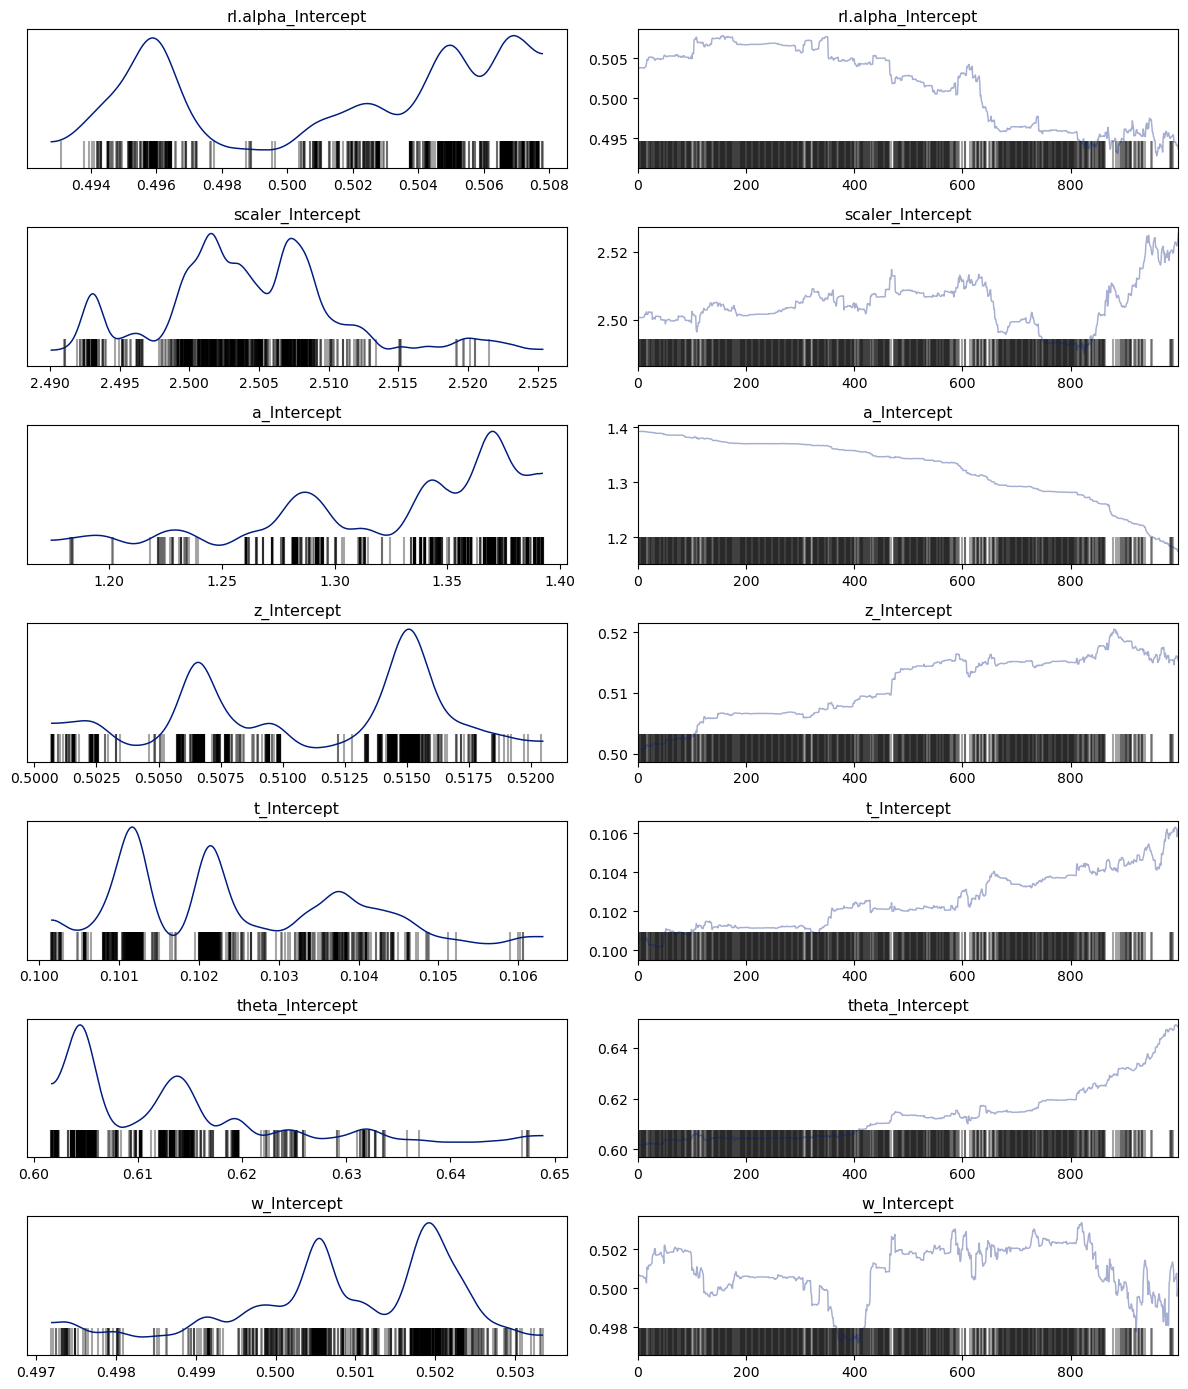

: 

: 

: 

: 

In [ ]:
list_group_mean_params = [
    "rl.alpha_Intercept",
    "scaler_Intercept",
    "a_Intercept",
    "z_Intercept",
    "t_Intercept",
    "theta_Intercept",
    "w_Intercept"
]

list_group_sd_params = [
    "rl.alpha_1|participant_id_sigma",
    "scaler_1|participant_id_sigma",
    "a_1|participant_id_sigma", 
    "z_1|participant_id_sigma",
    "t_1|participant_id_sigma",
    "theta_1|participant_id_sigma",
    "w_1|participant_id_sigma"
]

az.plot_trace(idata_mcmc, var_names=list_group_mean_params,
            #   lines=[(key_, {}, ground_truth_params[key_]) for key_ in ground_truth_params]
              )
plt.tight_layout()

/Users/jungsun/opt/anaconda3/envs/hssm/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (35), generating only 20 plots
  warnings.warn(
/Users/jungsun/opt/anaconda3/envs/hssm/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


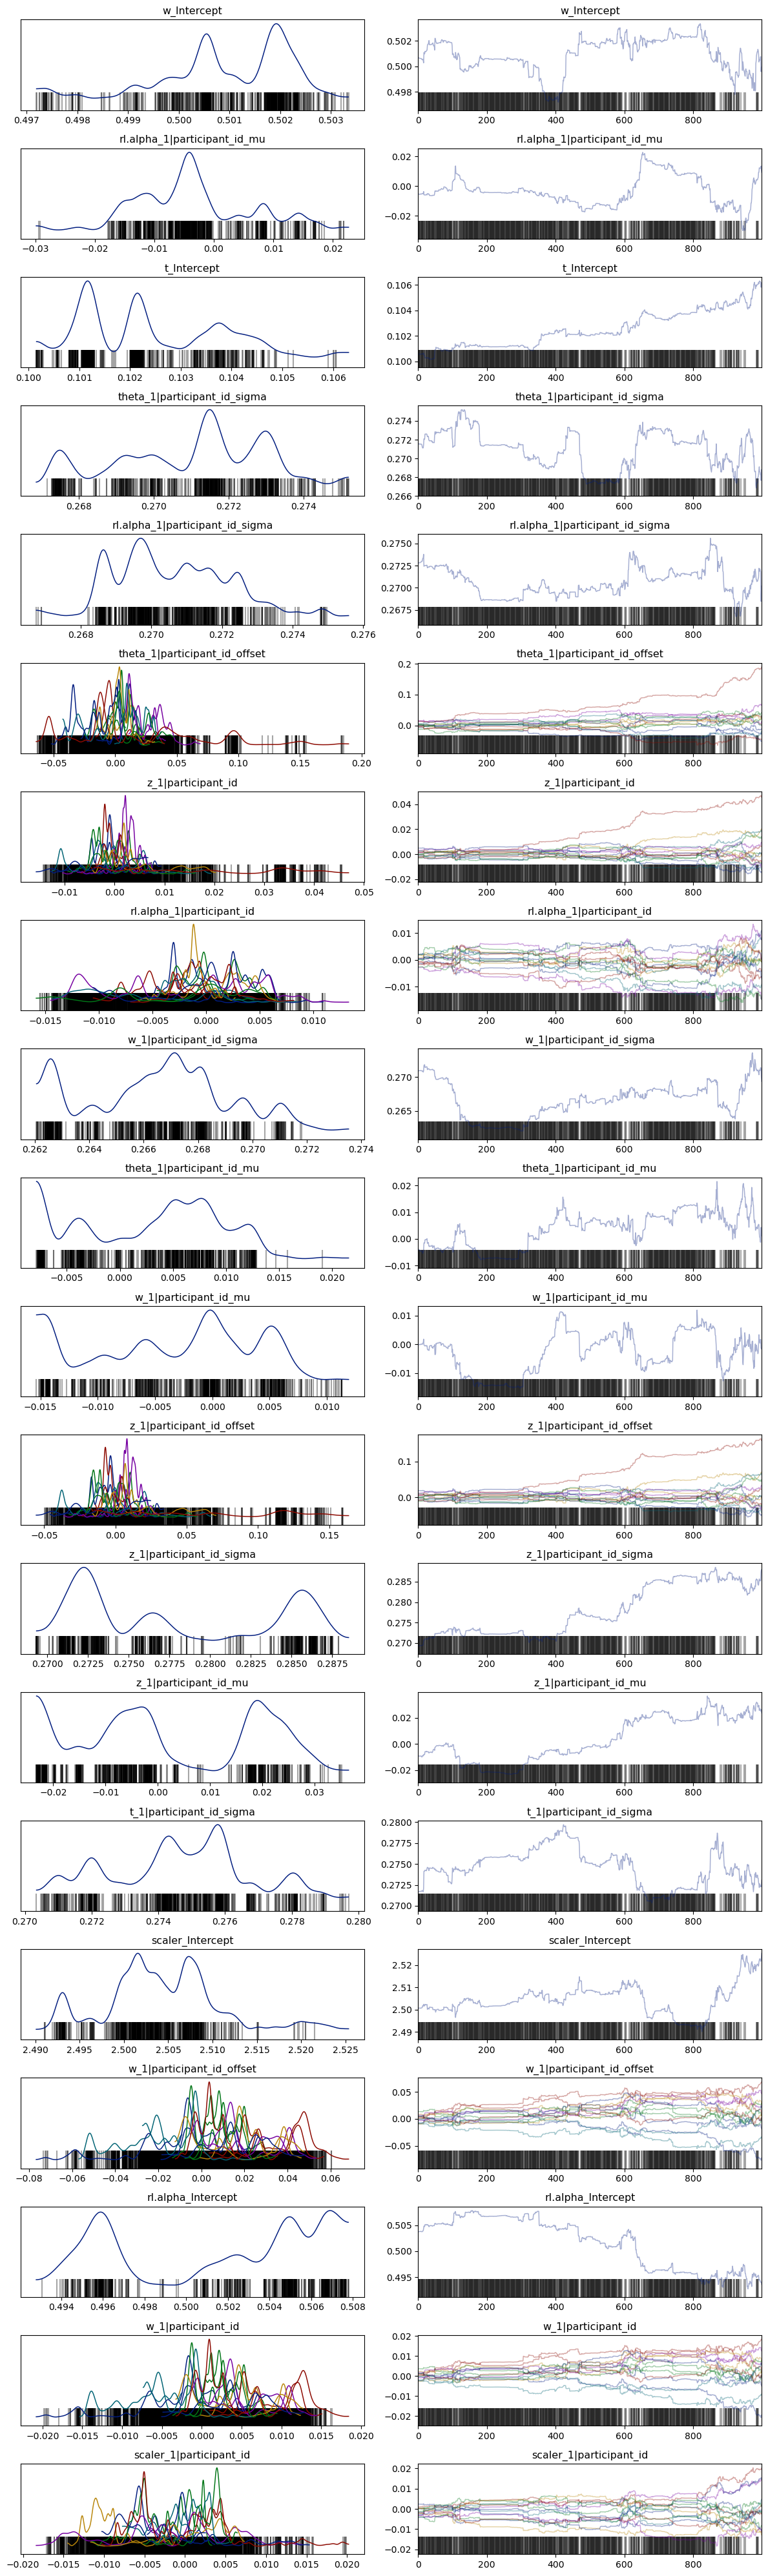

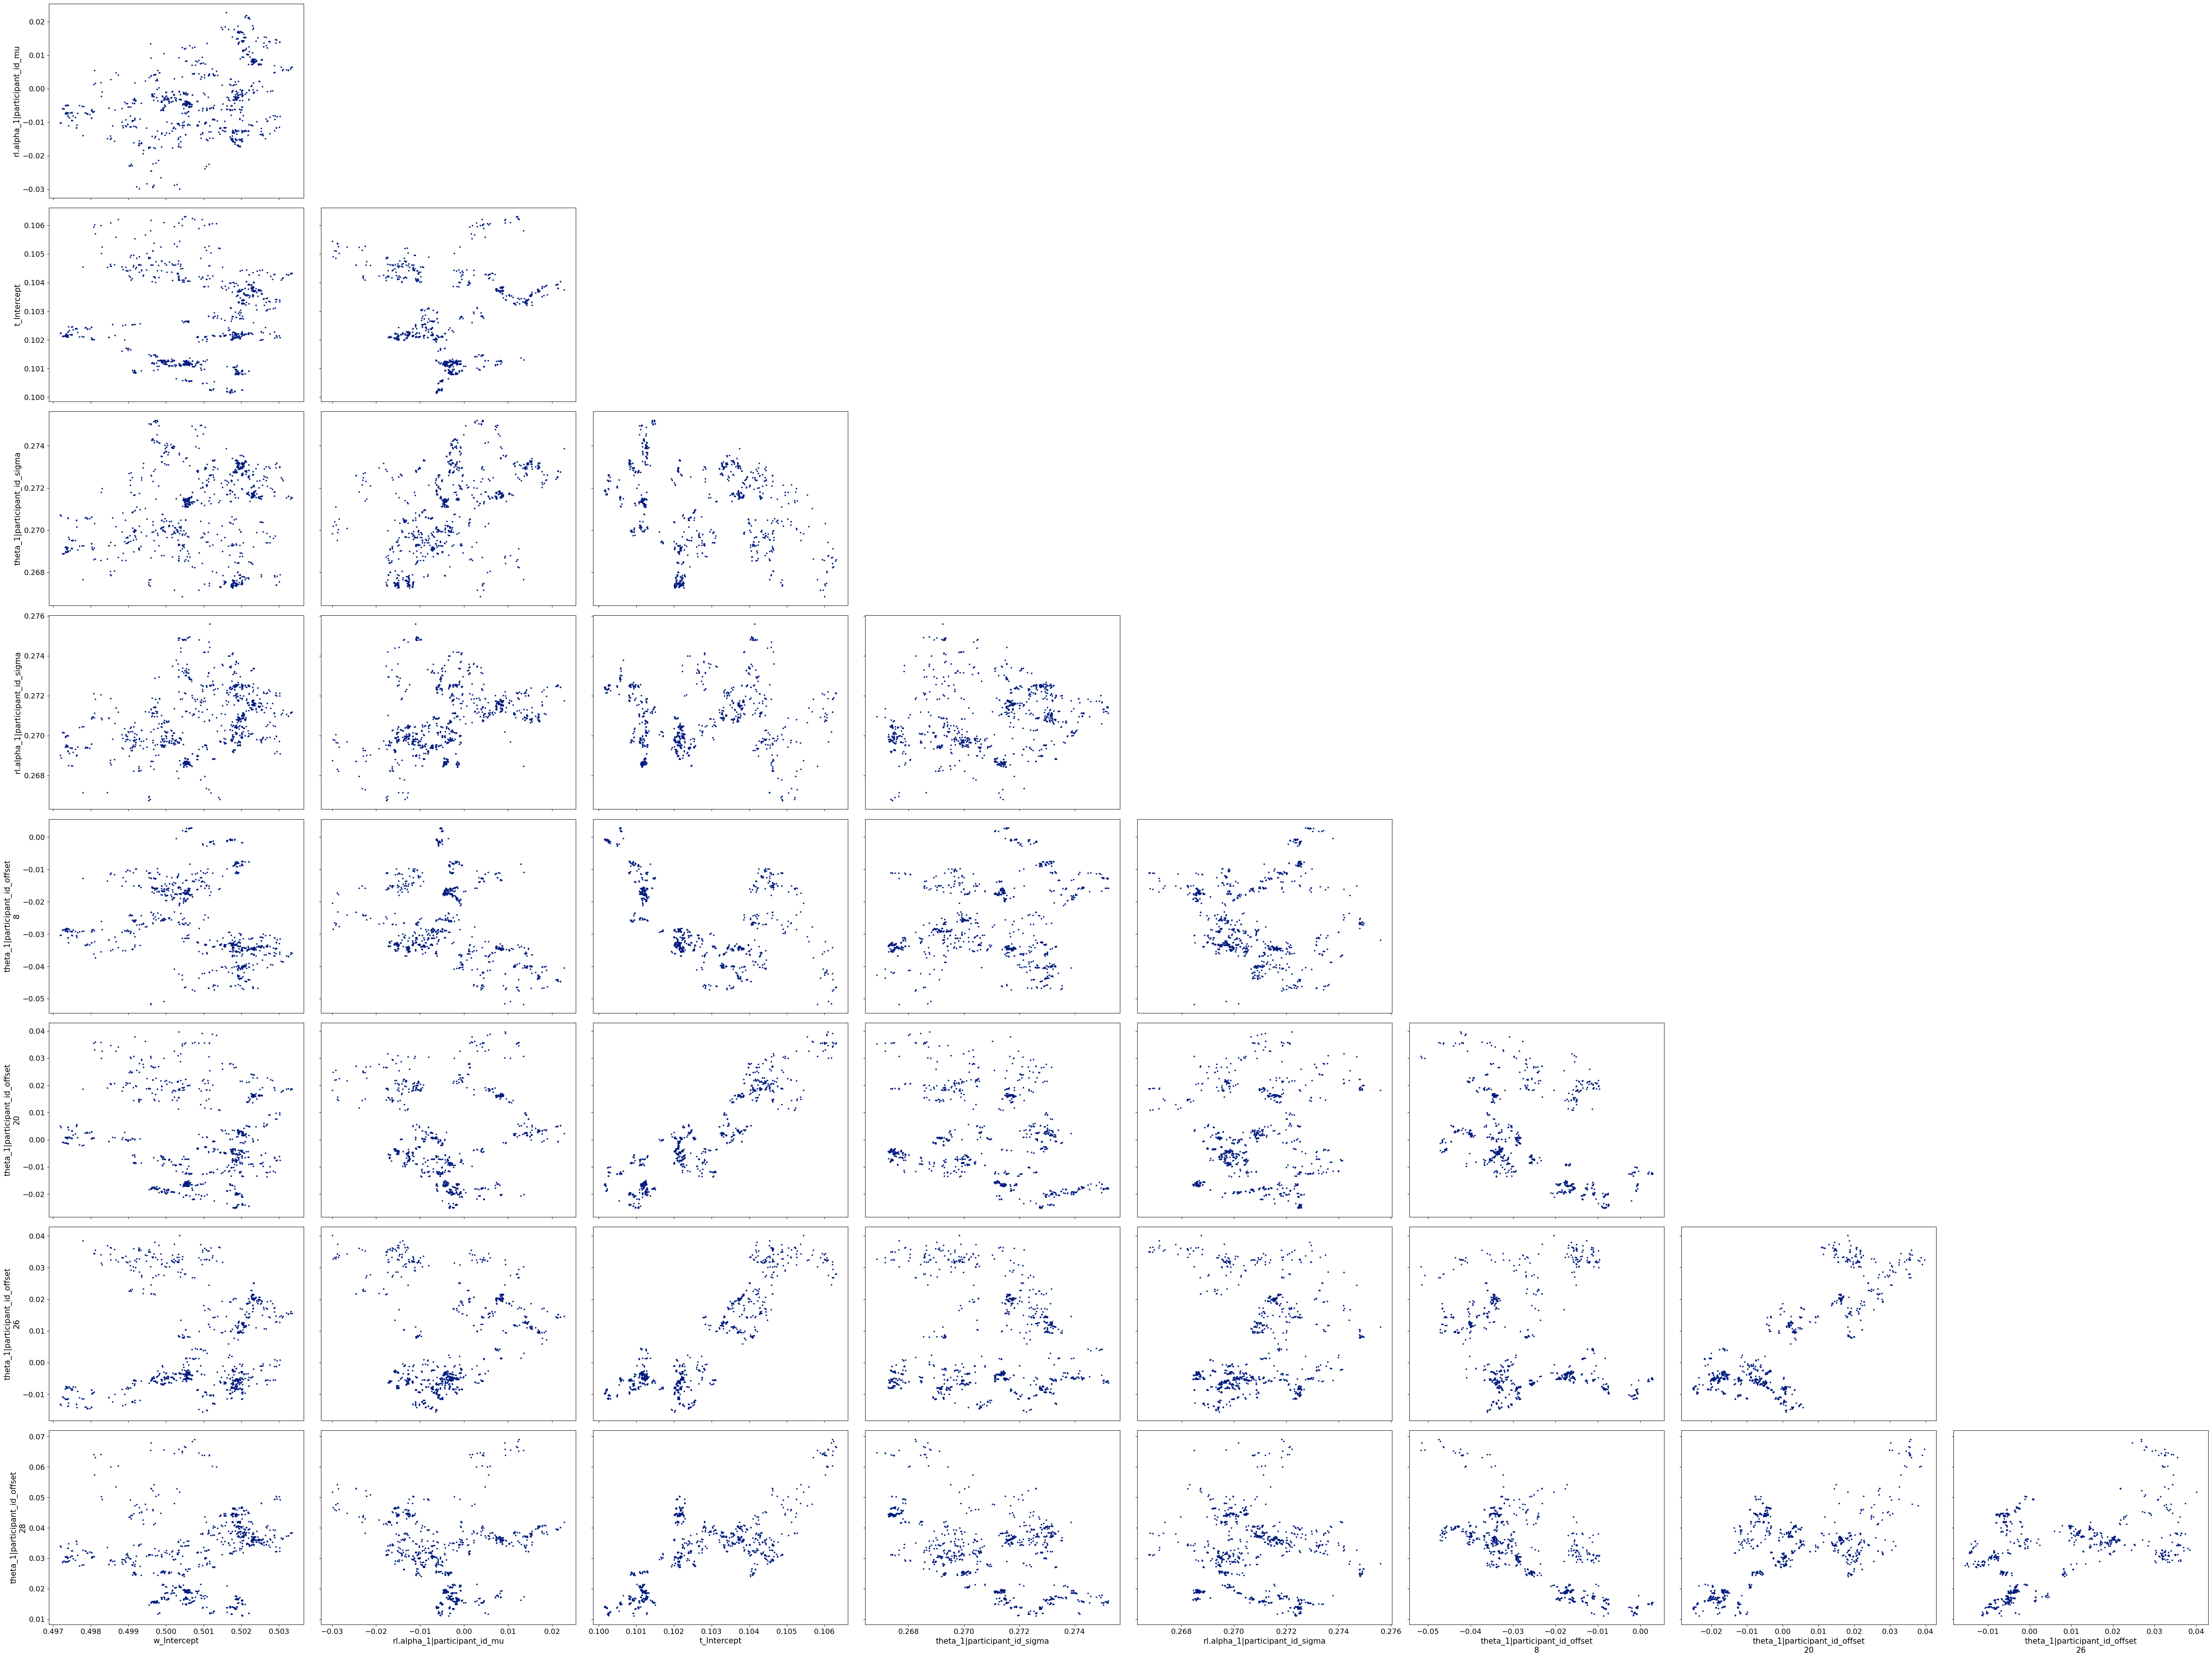

: 

: 

: 

: 

In [ ]:
az.plot_trace(hssm_model.traces)
plt.tight_layout()
az.plot_pair(hssm_model.traces)
plt.tight_layout()

: 

: 

: 

: 

# Assess the model fits

We examine the quality of fits by comparing the recovered parameters with the ground-truth data generating parameters of the simulated dataset. 
We examine the quality of fits both at group-level as well as subject-level.

## Examining group-level posteriors

In [ ]:
# Define parameter names for analysis

list_group_mean_params = [
    "rl.alpha_Intercept",
    "scaler_Intercept",
    "a_Intercept",
    "z_Intercept",
    "t_Intercept",
    "theta_Intercept",
    "w_Intercept"
]

list_group_sd_params = [
    "rl.alpha_1|participant_id_sigma",
    "scaler_1|participant_id_sigma",
    "a_1|participant_id_sigma", 
    "z_1|participant_id_sigma",
    "t_1|participant_id_sigma",
    "theta_1|participant_id_sigma",
    "w_1|participant_id_sigma"
]

: 

: 

: 

: 

In [ ]:
# Create mapping from HSSM model parameter names to ground truth values.
def create_ground_truth_mapping(savefile):

    return {
    "rl.alpha_Intercept": savefile['params_true_group']['rl_alpha_mean'],
    "scaler_Intercept": savefile['params_true_group']['scaler_mean'],
    "a_Intercept": savefile['params_true_group']['a_mean'],
    "z_Intercept": savefile['params_true_group']['z_mean'],
    "t_Intercept": savefile['params_true_group']['t_mean'],
    "theta_Intercept": savefile['params_true_group']['theta_mean'],
    "w_Intercept": savefile['params_true_group']['w_mean']
}

ground_truth_params = create_ground_truth_mapping(dataset)
print("Ground truth group means:\n")
for param, value in ground_truth_params.items():
    print(f"{param}: {value:.3f}")

KeyError: 'params_true_group'

: 

: 

: 

: 

In [ ]:
# Plot posterior distributions and MCMC traces for group-level parameters
# Vertical lines show ground truth values for parameter recovery assessment
az.plot_trace(idata_mcmc, var_names=list_group_mean_params,
              lines=[(key_, {}, ground_truth_params[key_]) for key_ in ground_truth_params])
plt.tight_layout()

: 

: 

: 

: 

In [ ]:
# plot the posterior pair plots of the group-level parameters
# this will show the joint distributions and correlations between the group-level parameters.
az.plot_pair(idata_mcmc, var_names=list_group_mean_params, kind='kde', point_estimate='mean')
plt.tight_layout()

: 

: 

: 

: 

## Examining participant-level posteriors

In [ ]:
# Extract ground truth subject-level parameters from the synthetic dataset
# Reshape from dictionary format to matrix (subjects x parameters)
sim_param_list = np.zeros((20, 6))

for ind, p in enumerate(savefile['params_true_subj'].keys()):
    sim_param_list[:, ind] = savefile['params_true_subj'][p]

: 

: 

: 

: 

In [ ]:
# Function to extract subject-level parameters from inference data.
def extract_subject_parameters(idata, param_names):
    
    n_subjects = idata.posterior[f'{param_names[0]}_1|participant_id'].shape[-1]
    n_params = len(param_names)
    
    subject_params = np.zeros((n_subjects, n_params))
    
    for i, param in enumerate(param_names):
        intercept = np.mean(idata.posterior[f'{param}_Intercept'].values[0])
        random_effects = np.mean(idata.posterior[f'{param}_1|participant_id'].values[0], axis=0)
        subject_params[:, i] = intercept + random_effects
    
    return subject_params

# Extract recovered parameters
recov_param_list = extract_subject_parameters(idata_mcmc, model_config.list_params)

: 

: 

: 

: 

In [ ]:
plot_param_ranges = [[0.5, 0.9], [2.2, 3.5], [1.2, 2], [0, 0.4], [0.3, 0.7], [0.2, 0.5]]
plot_param_names = ["rl.alpha", "scaler", "a", "z", "t", "theta"]

: 

: 

: 

: 

In [ ]:
# Function to create parameter recovery plots comparing simulated vs recovered values
def plot_parameter_recovery(sim_params, recov_params, param_names, axes_limits, 
                          additional_data=None, additional_label=None, show_correlation=False):

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(param_names):
            ax.set_visible(False)
            continue

        x, y = sim_params[:, i], recov_params[:, i]
        
        # Scatter plot showing parameter recovery 
        ax.scatter(x, y, alpha=0.6, label='MCMC' if additional_data is None else 'MCMC')
            
        # Additional data if provided
        if additional_data is not None:
            z = additional_data[:, i]
            ax.scatter(x, z, alpha=0.6, marker='x', label=additional_label or 'Additional')
            ax.legend(loc='lower right')

        # Calculate and display correlation between true and recovered parameters
        if show_correlation:
            spearman_r, _ = spearmanr(x, y)
            ax.text(0.05, 0.93, f"R: {spearman_r:.2f}", transform=ax.transAxes, 
                        fontsize=12, verticalalignment='bottom')

        # Formatting subplot
        ax.set_title(param_names[i], fontsize=16)
        ax.set_xlim(axes_limits[i])
        ax.set_ylim(axes_limits[i])
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.axline((0, 0), linestyle='--', slope=1, c='k', alpha=0.8)  # Perfect recovery line

    # Add axis labels
    fig.text(0.5, 0.02, 'Simulated', ha='center', fontsize=20)
    fig.text(0.02, 0.5, 'Recovered', va='center', rotation='vertical', fontsize=20)

    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    return fig

# Plot parameter recovery
plot_parameter_recovery(sim_param_list, recov_param_list, plot_param_names, plot_param_ranges, show_correlation=True)
plt.show()

: 

: 

: 

: 

# Estimating the posterior using Variation Inference (VI)

In [ ]:
# Run variational inference (VI) as a faster alternative to MCMC
# VI approximates the posterior with a simpler distribution family
idata_vi = hssm_model.vi(
    niter=30000,    # Number of optimization iterations
    draws=1000,     # Number of samples from approximate posterior
    method="advi"   # Automatic Differentiation Variational Inference
)

: 

: 

: 

: 

We now examine the VI loss over iterations. In general, this looks good with the caveat that there are oscillations during the initial iterations. In principle, this could arise from the model geometry, priors or simply because of an aggressive learning rate. We recommend users experiment with different settings to figure out what works best for their model.

In [ ]:
plt.plot(hssm_model.vi_approx.hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")

: 

: 

: 

: 

In [ ]:
idata_vi

: 

: 

: 

: 

In [ ]:
# Extract VI recovered parameters
recov_param_list_vi = extract_subject_parameters(idata_vi, model_config.list_params)

: 

: 

: 

: 

In [ ]:
# Plot comparison between MCMC and VI recovery
plot_parameter_recovery(
    sim_param_list, 
    recov_param_list, 
    plot_param_names, 
    plot_param_ranges,
    additional_data=recov_param_list_vi,
    additional_label='VI',
    show_correlation=False
)
plt.show()

: 

: 

: 

: 

## Compare MCMC and VI parameter recoveries

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

# Define constant for group mean parameters
list_group_mean_params = [
    "rl.alpha_Intercept",
    "scaler_Intercept",
    "a_Intercept",
    "z_Intercept",
    "t_Intercept",
    "theta_Intercept",
]

def plot_posterior_comparison(idata_list, labels, var_names, title_suffix=""):
    """Plot posterior density comparisons between different inference methods."""
    axes = az.plot_density(
        idata_list,
        data_labels=labels,
        var_names=var_names,
        hdi_prob=1.0,
        shade=0.2,
    )

    fig = axes.flatten()[0].get_figure()

    if title_suffix:
        fig.suptitle(f"Posterior Comparison - {title_suffix}", y=1.02)

    plt.tight_layout()
    
    return fig

# Compare group-level means
plot_posterior_comparison(
    [idata_mcmc, idata_vi], 
    ["NUTS", "VI"], 
    list_group_mean_params,
    "Group Means"
)
plt.show()

: 

: 

: 

: 

In [ ]:
# Compare group-level standard deviations  
plot_posterior_comparison(
    [idata_mcmc, idata_vi],
    ["NUTS", "VI"],
    list_group_sd_params, 
    "Group Standard Deviations"
)
plt.show()

: 

: 

: 

: 

While the VI and MCMC posteriors largely agree with each other, there are major discrepancies in parameters such as 't'. This is partly because of the fact that we are using mean field approximation for VI which relaxes the structure of covariance present in the model (eg. we also see that the VI posteriors are more peaked). While this tutorial is meant to serve as a proof-of-concept for RLSSM paradigm, we encourage users to leverage the HSSM functionality by tweaking and fine-tuning various settings including the choice of Bayesian inference method (say, VI vs MCMC) for robust results. 

: 

: 

: 

: 